In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Укажите путь к базе данных
db_path = '/Users/andrey/PycharmProjects_pro/SmartMoney/app/database/trading_labels.db'

# Подключаемся к базе данных
conn = sqlite3.connect(db_path)


# SQL-запрос для извлечения всех данных из таблицы trades
query = "SELECT * FROM trades"

# Загружаем данные в DataFrame
df = pd.read_sql_query(query, conn)

# Закрываем соединение
conn.close()

# Выводим первые несколько строк DataFrame
df.head()

,id,pair,ts_start,trade_duration,result
0,1,SPELLUSDT,1719965700000,76,Sell
1,2,BATUSDT,1723039200000,49,Ignore
2,3,WUSDT,1727517600000,46,Sell
3,4,COSUSDT,1727701200000,7,Sell
4,5,ARUSDT,1684386900000,611,Sell


In [2]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228440 entries, 0 to 228439
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              228440 non-null  int64 
 1   pair            228440 non-null  object
 2   ts_start        228440 non-null  int64 
 3   trade_duration  228440 non-null  int64 
 4   result          228440 non-null  object
dtypes: int64(3), object(2)
memory usage: 8.7+ MB


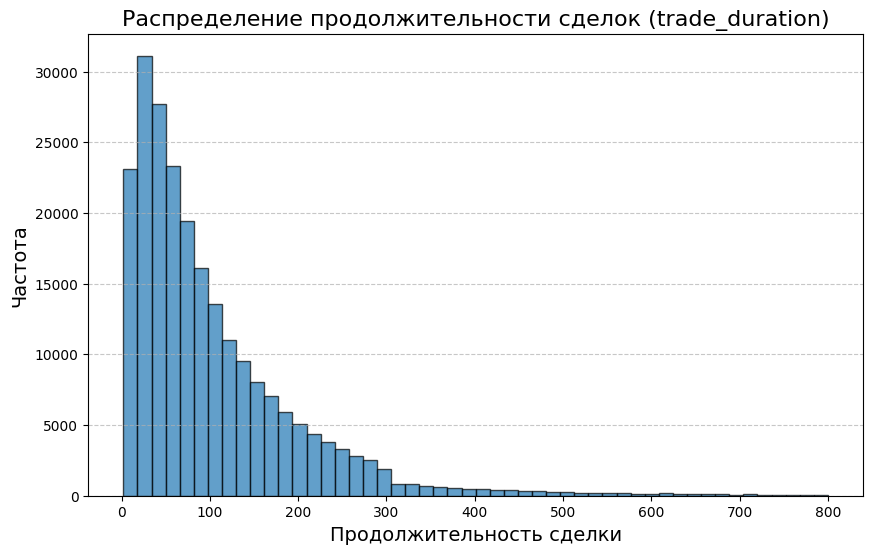

In [3]:
# Построение гистограммы для trade_duration
plt.figure(figsize=(10, 6))
plt.hist(df['trade_duration'], bins=50, edgecolor='black', alpha=0.7)

# Подписи и заголовок
plt.title('Распределение продолжительности сделок (trade_duration)', fontsize=16)
plt.xlabel('Продолжительность сделки', fontsize=14)
plt.ylabel('Частота', fontsize=14)

# Отображение
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [4]:
filtered_trades = df[(df['trade_duration'] > 3) & (df['trade_duration'] < 300)]

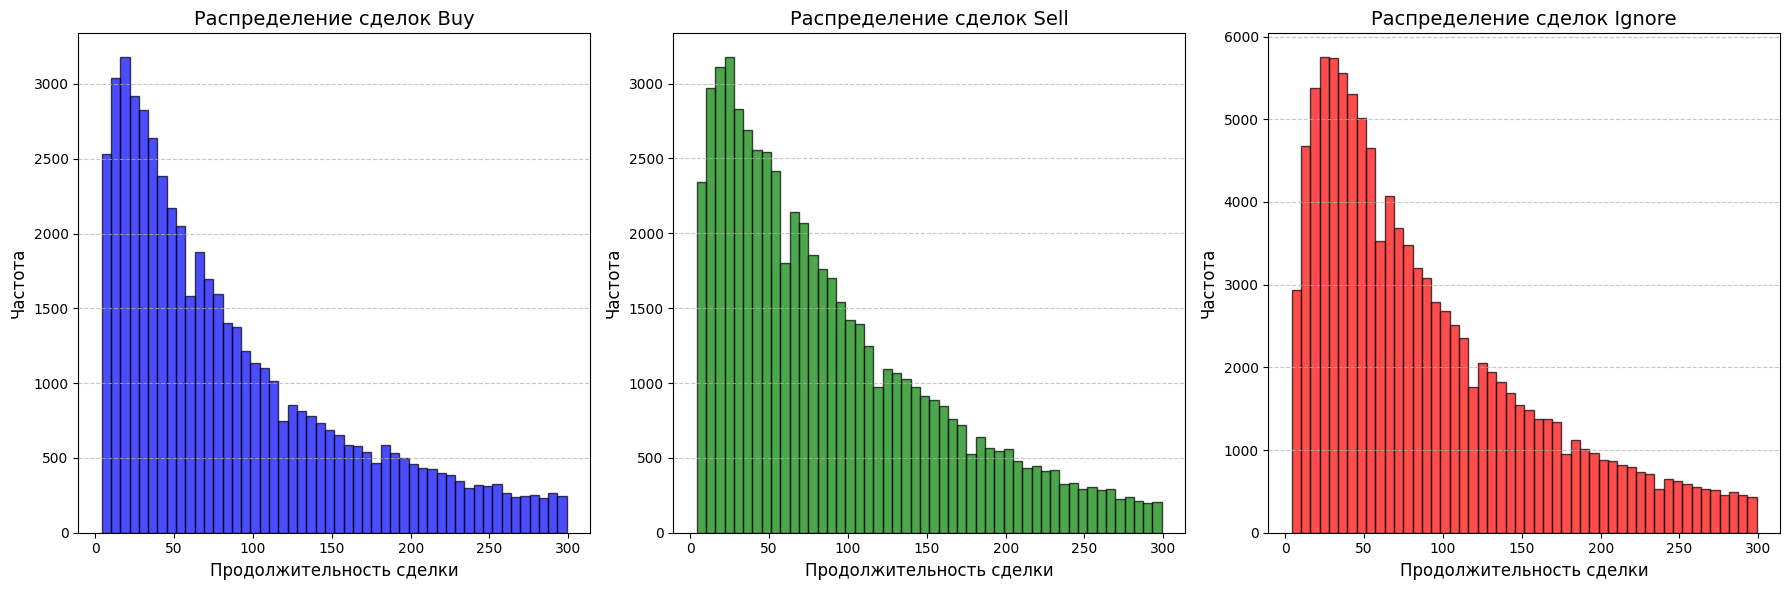

In [5]:
# Фильтрация сделок по результату
buy_trades = filtered_trades[filtered_trades['result'] == 'Buy']
sell_trades = filtered_trades[filtered_trades['result'] == 'Sell']
ignore_trades = filtered_trades[filtered_trades['result'] == 'Ignore']

# Построение гистограмм на одном экране
plt.figure(figsize=(18, 6))

# Гистограмма для Buy
plt.subplot(1, 3, 1)
plt.hist(buy_trades['trade_duration'], bins=50, edgecolor='black', alpha=0.7, color='blue')
plt.title('Распределение сделок Buy', fontsize=14)
plt.xlabel('Продолжительность сделки', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Гистограмма для Sell
plt.subplot(1, 3, 2)
plt.hist(sell_trades['trade_duration'], bins=50, edgecolor='black', alpha=0.7, color='green')
plt.title('Распределение сделок Sell', fontsize=14)
plt.xlabel('Продолжительность сделки', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Гистограмма для Ignore
plt.subplot(1, 3, 3)
plt.hist(ignore_trades['trade_duration'], bins=50, edgecolor='black', alpha=0.7, color='red')
plt.title('Распределение сделок Ignore', fontsize=14)
plt.xlabel('Продолжительность сделки', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отображение графиков
plt.tight_layout()
plt.show()

In [6]:
df.groupby('result').size().reset_index(name='count')

,result,count
0,Buy,54433
1,Ignore,112834
2,Sell,61173


In [7]:
filtered_trades.groupby('result').size().reset_index(name='count')

,result,count
0,Buy,52242
1,Ignore,107459
2,Sell,58747


In [8]:
def sample_balanced_data(df, categories, sample_size=50000):
    """
    Отбирает сбалансированные данные по категориям.

    :param df: DataFrame с данными.
    :param categories: Список категорий для сбалансирования.
    :param sample_size: Количество записей для каждой категории.
    :return: Сбалансированный DataFrame.
    """
    balanced_data = []
    for category in categories:
        category_data = df[df['result'] == category].drop_duplicates()  # Удаляем дубликаты
        sampled_data = category_data.sample(n=min(sample_size, len(category_data)), random_state=42)
        balanced_data.append(sampled_data)

    return pd.concat(balanced_data, ignore_index=True)

# Категории для балансировки
categories = ['Buy', 'Ignore', 'Sell']

# Отбираем сбалансированные данные
balanced_df = sample_balanced_data(df, categories)
balanced_df['status'] = 'new'
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Вывод количества записей по категориям
print(balanced_df['result'].value_counts())

result
Ignore    50000
Buy       50000
Sell      50000
Name: count, dtype: int64


In [10]:
def save_to_new_table(df, db_path, table_name='balanced_trades'):
    """
    Сохраняет DataFrame в новую таблицу в SQLite базе данных.

    :param df: DataFrame с данными для сохранения.
    :param db_path: Путь к базе данных.
    :param table_name: Имя новой таблицы.
    """
    # Подключение к базе данных
    conn = sqlite3.connect(db_path)

    try:
        # Сохранение DataFrame в новую таблицу
        df.to_sql(table_name, conn, if_exists='replace', index=False)
        print(f"Данные успешно записаны в таблицу '{table_name}'.")
    except Exception as e:
        print(f"Ошибка при сохранении данных: {e}")
    finally:
        # Закрытие соединения
        conn.close()

# Путь к базе данных
db_path = '/Users/andrey/PycharmProjects_pro/SmartMoney/app/database/trading_labels.db' # Укажите корректный путь

# Сохранение сбалансированных данных в новую таблицу
save_to_new_table(balanced_df, db_path, table_name='balanced_trades')

Данные успешно записаны в таблицу 'balanced_trades'.
